# Geocluster Development Script

In [1]:
import requests
import pandas as pd
import geopandas as gpd
import io
from netCDF4 import Dataset, num2date
import xarray as xr
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
import math

import numpy as np
import rasterio
from rasterio.features import shapes
#from affine import Affine
from shapely.geometry import shape, MultiPolygon, MultiPoint, Point
from shapely.ops import unary_union, transform
from descartes import PolygonPatch
from itertools import product
import pyproj

**Stage 1 of the THERMOSS project**: creation of geoclusters for district heating and cooling catalogue

This script corresponds to the stage 1 of the THERMOSS project which goal was the creation of geoclusters of similar characterisitcs (energy, climate and building typology related) to help stakeholders choose the most suited technologies to implement. The idea behind is that if a technology has proven being efficient within a certain geocluster, it is most likely that the solution can be reproducible in other location of this same geocluster.

**Input dataset:**<br>

The table below gives the list of features that have been used to create the geoclusters. Those are believed to be the most influencial parameters for heating and cooling loads.

*Note: Environmental conditions taken from NetCDF (Network Common Data Form) meteorology dataset. The dataset used cover the area: 25N-75N x 40W-75E (extended Europe) with a 0.5 degree regular lat-lon grid with daily mean temperature from 1950-01-01 to 2016-08-31 (ENSEMBLES project 2017).*

| Parameter | Source |
|:-----------------------------------------------------------------|:--------------------------------------------------------------|
| **Environmental conditions** |  |
| Cold season mean temperature (C) | (ENSEMBLES project 2017) |
| Cold season mean temperature (C) | (ENSEMBLES project 2017) |
| **Building typology** |  |
| Residential building energy use (KWh/m2) | (EU Buildings Observatory 2017) |
| Non-residential building energy use (kWh/m2) | (EU Buildings Observatory 2017) |
| Single family unit U-value | http://webtool.building-typology.eu/#bm |
| Multiple family unit U-value | http://webtool.building-typology.eu/#bm |
| Single family unit floor area (m2) | http://webtool.building-typology.eu/#bm |
| Multiple family unit floor area (m2) | http://webtool.building-typology.eu/#bm |
| **Building stock** |  |
| Residential building stock (%) | (EU Buildings Observatory 2017) |
| Single family stock (% of residential) | (EU Buildings Observatory 2017) |
| **Economic considerations** |  |
| Energy use (kg of oil equivalent per capita) | (World Bank Group 2017) |
| Gas prices for domestic consumers (€/kWh ex. VAT) | (European Commission 2017) |
| Gas prices for industrial consumers (€/kWh ex. VAT) | (European Commission 2017) |
| Electricity prices for domestic consumers (€/kWh ex. VAT) | (European Commission 2017) |
| Electricity prices for industrial consumers (€/kWh ex. VAT) | (European Commission 2017) |
| Share of renewable energy in gross final energy consumption (%) | (European Environment Agency 2016; European Commission 2017) |


## Inputs

## countries list

In [2]:
countries = pd.read_csv('countries.csv')

In [3]:
shpFilePath = r'european-union-countries.geojson'
eu_df = gpd.read_file(shpFilePath)
#shapeData.set_index('NAME', inplace=True)
eu_df.to_crs('EPSG:3857', inplace=True)

In [4]:
eu_df = eu_df.merge(countries, left_on='admin',right_on='Name', how='left')

In [5]:
eu = eu_df.geometry.values.unary_union()

### energy

In [6]:
url = "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/T2020_RD330/?format=CSV"
urlData = requests.get(url).content

In [7]:
renew_df = pd.read_csv(io.StringIO(urlData.decode('utf-8')))
renew_df.iloc[:,0] = renew_df.iloc[:,0].apply(lambda x: x.split(';')[-1])
renew_df.rename(columns={'freq;nrg_bal;unit;geo\TIME_PERIOD': 'CODE'},inplace=True)
renew_df

,CODE,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,AL,29.621,31.367,32.070,32.657,32.448,31.437,31.867,31.187,35.152,33.167,31.856,34.896,36.939,35.898,36.844,36.667
1,AT,22.554,24.355,26.277,28.145,28.790,31.041,31.207,31.553,32.736,32.666,33.553,33.502,33.374,33.141,33.806,33.626
2,BA,20.274,19.752,19.213,18.701,16.708,18.471,18.710,17.995,18.014,19.307,24.873,26.607,25.358,23.241,35.972,37.578
3,BE,1.890,2.332,2.633,3.101,3.590,4.715,6.002,6.275,7.089,7.650,8.043,8.026,8.752,9.113,9.478,9.924
4,BG,9.231,9.173,9.415,9.098,10.345,12.005,13.928,14.152,15.837,18.898,18.050,18.261,18.760,18.701,20.592,21.564
5,CY,3.071,3.131,3.263,4.004,5.134,5.925,6.173,6.261,7.137,8.456,9.173,9.929,9.859,10.503,13.898,13.800
6,CZ,6.774,7.115,7.363,7.895,8.675,9.978,10.514,10.945,12.813,13.927,15.073,15.067,14.924,14.796,15.138,16.244
7,DE,6.207,7.167,8.466,10.039,10.072,10.851,11.667,12.453,13.543,13.760,14.385,14.906,14.889,15.476,16.673,17.354
8,DK,14.840,15.956,16.334,17.748,18.544,19.949,21.889,23.390,25.466,27.174,29.323,30.866,32.052,34.677,35.413,37.204
9,EA19,8.400,8.997,9.679,10.768,11.450,12.629,13.155,13.128,14.621,15.264,16.079,16.446,16.697,17.271,17.770,18.573


In [8]:
renew_df = renew_df[['CODE','2019 ']].rename(columns={'2019 ': 'renew share'}).set_index('CODE')

In [9]:
url = "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/T2020_RK200/?format=CSV"
urlData = requests.get(url).content

In [10]:
energy_df = pd.read_csv(io.StringIO(urlData.decode('utf-8')))
energy_df.iloc[:,0] = energy_df.iloc[:,0].apply(lambda x: x.split(';')[-1])
energy_df.rename(columns={'freq;siec;unit;nrg_bal;geo\TIME_PERIOD': 'CODE'},inplace=True)
energy_df

,CODE,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,AL,527.995,531.026,508.966,469.652,452.131,474.021,516.029,493.527,483.591,...,489.039,498.280,509.086,580.003,556.243,532.287,496.350,492.580,510.484,:
1,AT,5881.122,6531.442,6164.417,6274.606,5917.381,6322.048,6961.087,6272.585,6379.629,...,7070.224,6551.691,6677.912,6923.356,6239.870,6631.937,6909.468,6955.601,6542.766,6695.287
2,BA,:,:,:,:,:,:,:,:,:,...,:,:,:,:,980.816,1113.030,1139.361,1045.641,1719.424,:
3,BE,8289.251,9151.751,9147.798,9091.449,8937.893,9320.715,10619.932,9883.169,9911.078,...,9614.660,8000.830,8477.623,9098.495,7489.331,8270.398,8313.535,8180.798,8118.234,7899.465
4,BG,2336.070,2479.321,2626.804,2829.252,2443.498,2447.466,2685.130,2213.172,2424.369,...,2243.338,2374.281,2352.559,2241.036,2164.991,2192.912,2252.111,2318.716,2229.673,2159.861
5,CY,106.518,108.496,130.393,130.331,136.539,140.664,147.299,151.381,156.186,...,336.524,356.538,351.763,306.622,293.742,326.614,335.594,345.146,337.179,362.606
6,CZ,7343.440,7027.503,6493.784,6392.034,6410.515,6584.005,7341.635,6989.250,6575.111,...,7440.711,6863.723,7115.570,7269.133,6554.173,6769.510,7090.172,7202.965,7042.708,7006.728
7,DE,63146.022,65038.309,62291.711,66393.555,63846.118,66361.722,72456.181,71390.388,70377.801,...,63839.122,56020.249,59188.124,62517.628,53648.149,54959.824,56963.580,56542.893,55852.400,57743.118
8,DK,4043.774,4391.519,4226.278,4586.545,4423.659,4524.092,4831.970,4521.943,4505.559,...,5005.148,4496.279,4444.462,4484.143,4146.276,4448.177,4604.692,4496.293,4444.030,4369.619
9,EA19,179569.676,192109.206,185598.934,189143.685,181785.221,187502.891,203164.435,196055.103,197838.574,...,216394.395,193415.378,203410.774,207706.184,180638.205,189410.638,194529.844,193820.108,190498.869,191574.847


In [11]:
energy_df = energy_df[['CODE','2019 ']].rename(columns={'2019 ': 'energy cons'}).set_index('CODE')

In [12]:
url = "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/TEN00118/?format=CSV"
urlData = requests.get(url).content

In [13]:
gas_df = pd.read_csv(io.StringIO(urlData.decode('utf-8')))
gas_df['type'] = gas_df.iloc[:,0].apply(lambda x: x.split(';')[-2])
gas_df.iloc[:,0] = gas_df.iloc[:,0].apply(lambda x: x.split(';')[-1])
gas_df.rename(columns={'freq;product;currency;unit;indic_en;geo\TIME_PERIOD': 'CODE'},inplace=True)
gas_df

,CODE,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,type
0,AT,18.0300,17.2900,19.2900,21.0500,21.3200,20.7800,20.2800,19.1700,18.7100,18.5850,18.3400,17.9895,MSHH
1,BA,:,10.4796,12.5510,15.4082,15.4082,14.2347,14.2650,10.8598,8.5335,9.0462,9.3109,10.3855,MSHH
2,BE,16.8200,14.7000,17.6000,19.1300,18.3200,18.2700,16.2300,15.1900,14.5114,14.8847,15.3755,13.7697,MSHH
3,BG,13.1404,10.2107,11.9440,13.7233,14.2397,13.6261,13.2580,10.2260,9.1778,10.5356,12.4631,11.0110,MSHH
4,CZ,13.7480,13.0395,15.1247,18.3111,17.8029,15.2285,15.9493,16.1879,15.2685,15.9675,16.2682,15.9069,MSHH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,SI,11.3400,10.8766,11.1900,14.8000,12.3800,10.6400,8.9300,8.1800,7.1900,7.6043,8.5024,6.8561,MSIND
69,SK,11.1200,8.7390,9.2200,10.6000,9.8800,9.9100,9.2900,8.1100,7.4748,7.6680,9.1350,8.1740,MSIND
70,TR,7.7118,6.3672,5.7822,6.7818,8.2623,6.5550,7.5261,6.6187,5.0315,4.7541,5.7577,5.9961,MSIND
71,UA,:,:,:,:,:,:,:,:,7.2733,6.8203,7.1643,4.2910,MSIND


In [14]:
gas_df = gas_df.set_index(['CODE','type'])['2019 '].unstack().rename(columns={'MSHH': 'residential gas price','MSIND':'indus gas price'})

In [15]:
url = "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/TEN00117/?format=CSV"
urlData = requests.get(url).content   

In [16]:
elc_df = pd.read_csv(io.StringIO(urlData.decode('utf-8')))
elc_df['type'] = elc_df.iloc[:,0].apply(lambda x: x.split(';')[-2])
elc_df.iloc[:,0] = elc_df.iloc[:,0].apply(lambda x: x.split(';')[-1])
elc_df.rename(columns={'freq;product;currency;unit;indic_en;geo\TIME_PERIOD': 'CODE'},inplace=True)
elc_df

,CODE,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,type
0,AL,:,:,0.1152,0.1163,0.1156,0.1156,0.0812,0.0824,0.0844,:,0.0920 e,:,MSHH
1,AT,0.1909,0.1967,0.1986,0.1975,0.2082,0.2021,0.2009,0.2034,0.1950,0.1966,0.2034,0.2102,MSHH
2,BA,:,0.0741,0.0745,0.0798,0.0803,0.0791,0.0812,0.0831,0.0859,0.0864,0.0873,0.0870,MSHH
3,BE,0.1916,0.1959,0.2136,0.2327,0.2173,0.2097,0.2126,0.2544,0.2857,0.2824,0.2839,0.2792,MSHH
4,BG,0.0823,0.0813,0.0826,0.0846,0.0924,0.0832,0.0942,0.0956,0.0955,0.0979,0.0997,0.0997,MSHH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,SK,0.1416,0.1161,0.1233,0.1273,0.1242,0.1107,0.1081,0.1047,0.0741,0.0790,0.0921,0.0977,MSIND
84,TR,0.0754,0.0863,0.0760,0.0831,0.0891,0.0720,0.0790,0.0722,0.0615,0.0571,0.0683,0.0774,MSIND
85,UA,:,:,:,:,:,:,:,:,:,0.0595,0.0656,0.0595,MSIND
86,UK,0.1077,0.0947,0.0939,0.1095,0.1124,0.1246,0.1184,0.1042,0.0938,0.0970,0.0998,0.1065,MSIND


In [17]:
 elc_df = elc_df.set_index(['CODE','type'])['2017 '].unstack().rename(columns={'MSHH': 'residential elec price','MSIND':'indus elec price'})

### Building stock

In [18]:
stock_df = pd.read_csv('building_stock.csv')
stock_df.rename(columns={'Unnamed: 0': 'Country'},inplace=True)
stock_df

,Country,Residential,Non-residential,single family,mutiple family
0,Austria,0.616,0.384,0.475,0.525
1,Belgium,0.675,0.325,0.729,0.271
2,Bulgaria,0.721,0.279,0.549,0.451
3,Croatia,0.777,0.223,0.659,0.341
4,Cyprus,0.862,0.138,0.635,0.365
5,Czech Republic,0.649,0.351,0.443,0.557
6,Denmark,0.722,0.278,0.595,0.405
7,Estonia,0.757,0.243,0.251,0.749
8,Finland,0.677,0.323,0.550,0.450
9,France,0.764,0.236,0.567,0.433


In [19]:
stock_df = stock_df.merge(countries,left_on='Country',right_on='Name',how='left')
stock_df = stock_df[['Code','Residential','Non-residential','single family','mutiple family']].set_index('Code')
stock_df

,Residential,Non-residential,single family,mutiple family
Code,,,,
AT,0.616,0.384,0.475,0.525
BE,0.675,0.325,0.729,0.271
BG,0.721,0.279,0.549,0.451
HR,0.777,0.223,0.659,0.341
CY,0.862,0.138,0.635,0.365
CZ,0.649,0.351,0.443,0.557
DK,0.722,0.278,0.595,0.405
EE,0.757,0.243,0.251,0.749
FI,0.677,0.323,0.550,0.450


### Building typology

In [20]:
typo_df = pd.read_csv('building_typo.csv')
typo_df.rename(columns={'Unnamed: 0': 'Country'},inplace=True)
typo_df

,Country,single family U value,multiple family U value,single family area (m2),mutiple family area (m2)
0,Austria,0.978513,0.882793,145,418.0
1,Belgium,1.019217,1.121330,220,1613.0
2,Bulgaria,1.182875,0.989048,172,495.0
3,Czech Republic,0.813539,0.967243,112,681.0
4,Denmark,0.479975,0.649674,127,NaN
5,France,0.991521,1.029668,106,481.0
6,Germany,0.722681,0.861979,173,1239.0
7,Greece,1.000192,NaN,162,884.0
8,Hungary,0.981335,0.796095,112,644.0
9,Ireland,0.802584,0.774515,123,NaN


In [21]:
typo_df = typo_df.merge(countries,left_on='Country',right_on='Name',how='left')
typo_df = typo_df[['Code','single family U value','multiple family U value','single family area (m2)','mutiple family area (m2)']].set_index('Code')
typo_df

,single family U value,multiple family U value,single family area (m2),mutiple family area (m2)
Code,,,,
AT,0.978513,0.882793,145,418.0
BE,1.019217,1.121330,220,1613.0
BG,1.182875,0.989048,172,495.0
CZ,0.813539,0.967243,112,681.0
DK,0.479975,0.649674,127,NaN
FR,0.991521,1.029668,106,481.0
DE,0.722681,0.861979,173,1239.0
GR,1.000192,NaN,162,884.0
HU,0.981335,0.796095,112,644.0


### Environmental conditions

In [22]:
with xr.open_dataset('tg_0.50deg_reg_1995-2016_v14.0.nc') as file:
    # You can open the data using the code below, however it you use rio.write_crs
    # it will ensure that crs for your data persist throughout your analysis
    # max_temp_xr = file_nc
    dsCDF = file.rio.write_crs("epsg:4326", inplace=True)
    
dsCDF

<xarray.Dataset>
Dimensions:      (latitude: 101, longitude: 232, time: 7914)
Coordinates:
  * longitude    (longitude) float32 -40.25 -39.75 -39.25 ... 74.25 74.75 75.25
  * latitude     (latitude) float32 25.25 25.75 26.25 ... 74.25 74.75 75.25
  * time         (time) datetime64[ns] 1995-01-01 1995-01-02 ... 2016-08-31
    spatial_ref  int32 0
Data variables:
    tg           (time, latitude, longitude) float32 ...
Attributes:
    Ensembles_ECAD:  14.0
    Conventions:     CF-1.4
    References:      http://www.ecad.eu\nhttp://www.ecad.eu/download/ensemble...
    history:         Mon Oct 17 11:28:47 2016: ncks -a -d time,16436,24349 tg...
    NCO:             "4.5.3"
    grid_mapping:    spatial_ref

In [23]:
#Create typical year from the 20 years'set with daily data point (grid X 366 days)
typical_year = dsCDF.groupby('time.dayofyear').median('time') 
typical_year

<xarray.Dataset>
Dimensions:      (dayofyear: 366, latitude: 101, longitude: 232)
Coordinates:
  * longitude    (longitude) float32 -40.25 -39.75 -39.25 ... 74.25 74.75 75.25
  * latitude     (latitude) float32 25.25 25.75 26.25 ... 74.25 74.75 75.25
    spatial_ref  int32 0
  * dayofyear    (dayofyear) int64 1 2 3 4 5 6 7 ... 360 361 362 363 364 365 366
Data variables:
    tg           (dayofyear, latitude, longitude) float32 nan nan ... nan nan

In [24]:
#Split typical year into seasonal bins (grid X 2 seasons)
day_bins = [0,106,289,366] #Limits of the 2 seasons (day number over the year)
typical_Seasonal_year = typical_year.groupby_bins('dayofyear',day_bins,labels=['cold1','hot','cold2']).median('dayofyear') #Split the year into 3 bins
Cold = typical_Seasonal_year.sel(dayofyear_bins = ['cold2','cold1']).mean('dayofyear_bins') #Average of the 2 "Cold" season bins
Hot = typical_Seasonal_year.sel(dayofyear_bins = ['hot']).mean('dayofyear_bins')
display(Cold)
display(Hot)

<xarray.Dataset>
Dimensions:      (latitude: 101, longitude: 232)
Coordinates:
  * longitude    (longitude) float32 -40.25 -39.75 -39.25 ... 74.25 74.75 75.25
  * latitude     (latitude) float32 25.25 25.75 26.25 ... 74.25 74.75 75.25
    spatial_ref  int32 0
Data variables:
    tg           (latitude, longitude) float32 nan nan nan nan ... nan nan nan

<xarray.Dataset>
Dimensions:      (latitude: 101, longitude: 232)
Coordinates:
  * longitude    (longitude) float32 -40.25 -39.75 -39.25 ... 74.25 74.75 75.25
  * latitude     (latitude) float32 25.25 25.75 26.25 ... 74.25 74.75 75.25
    spatial_ref  int32 0
Data variables:
    tg           (latitude, longitude) float32 nan nan nan nan ... nan nan nan

#### mask europe

In [25]:
Hot.rio.write_crs("epsg:4326", inplace=True)
Hot = Hot.rio.reproject(dst_crs='EPSG:3857')
Hot = Hot.rio.clip(eu)
Hot = Hot.where(Hot['tg'] != -9999.)  

Cold.rio.write_crs("epsg:4326", inplace=True)
Cold = Cold.rio.reproject(dst_crs='EPSG:3857')
Cold = Cold.rio.clip(eu)
Cold = Cold.where(Cold['tg'] != -9999.) 

#### raster to vector

In [26]:
#Hot.rio.write_crs("epsg:4326", inplace=True)
#Hot = Hot.rio.reproject(dst_crs='EPSG:3857')

hot_bins = Hot.quantile([0,0.25,0.5,0.75,1]).tg.values
Hot_discr = np.digitize(Hot.tg.values, hot_bins)
Hot_discr = Hot_discr.astype(np.int32)
#Hot_discr[Hot_discr == 5] = np.nan

west, east = min(Hot.x.values), max(Hot.x.values)
south, north =  min(Hot.y.values), max(Hot.y.values)
width = len(Hot.x.values)
height = len(Hot.y.values)

res_x = np.diff(Hot.x.values).mean()
res_y = np.diff(Hot.y.values).mean()

transform = rasterio.transform.from_origin(west, north, res_x, -res_y)

data = []
mask = Hot_discr != 5
for shp, val in shapes(Hot_discr,mask=mask, transform=transform):
    record = {'bin': val, 'geometry' : shape(shp)}
    data.append(record)
    
Hot_df = pd.DataFrame.from_records(data)
Hot_df = gpd.GeoDataFrame(Hot_df,crs=3857)
Hot_df = Hot_df.dissolve(by='bin')

<Figure size 432x288 with 0 Axes>

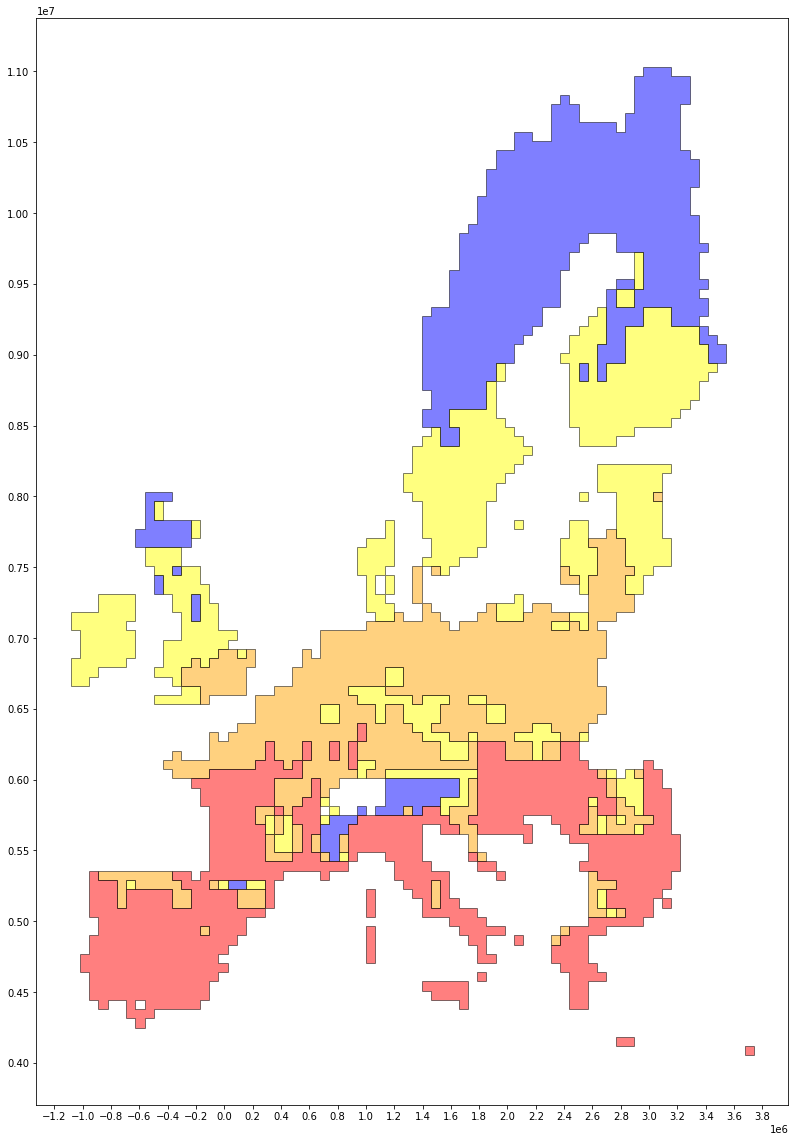

In [27]:
plt.clf()
ax = plt.figure(figsize=(20,20)).add_subplot(111)
colors = ['blue','yellow','orange','red']
for poly, color in zip(Hot_df['geometry'],colors):
    ax.add_patch(PolygonPatch(poly, fc=color, ec='black', alpha=0.5))
ax.axis('scaled')
plt.locator_params(axis='y', nbins=30)
plt.locator_params(axis='x', nbins=30)
plt.draw()
plt.show()

In [28]:
for index, row in Hot_df.iterrows():
    temp_poly = row.geometry.buffer(100*1000)
    temp_poly = temp_poly.intersection(eu)
    other_polys = Hot_df.loc[Hot_df.index != index].geometry.values.unary_union()
    to_remove = temp_poly.intersection(other_polys)
    temp_poly = temp_poly.difference(to_remove)

    # then we snap the geometry of row to the just created multipolygon
    # the snaped geometry overwrites the exisiting geometry in input_gdf
    Hot_df.loc[index,['geometry']]= temp_poly


<Figure size 432x288 with 0 Axes>

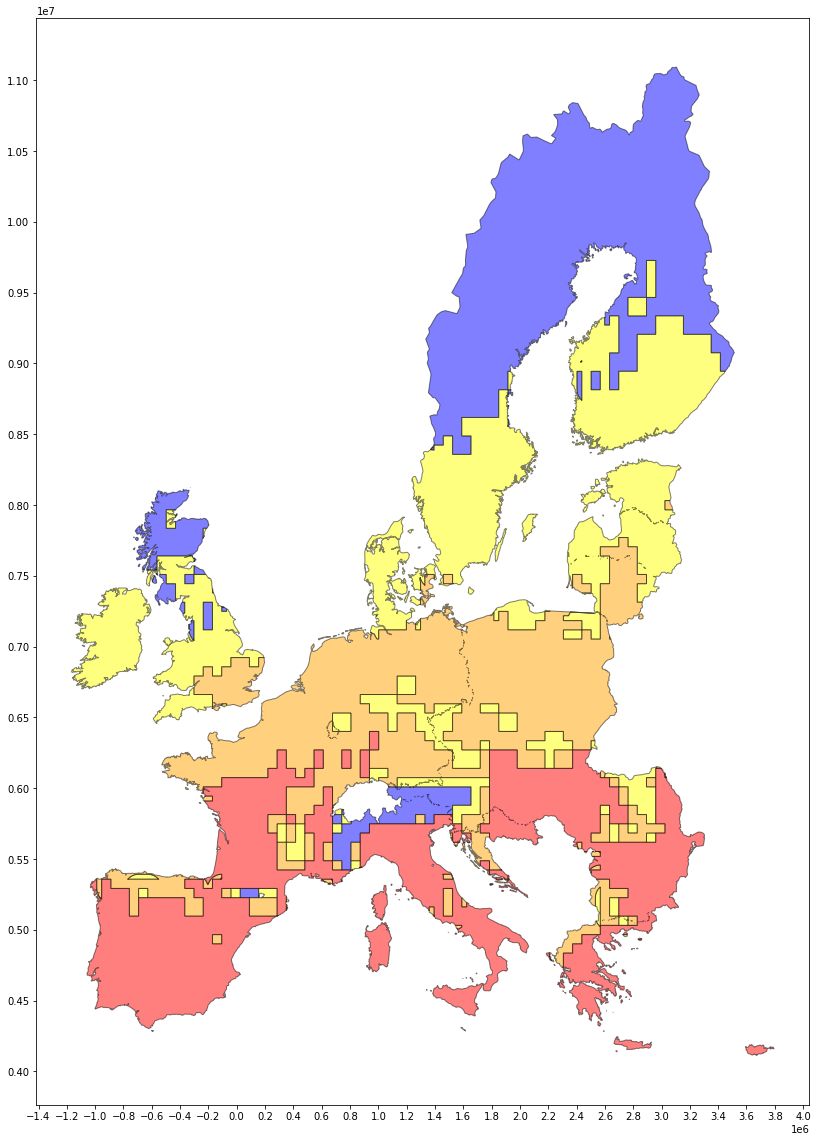

In [29]:
plt.clf()
ax = plt.figure(figsize=(20,20)).add_subplot(111)
colors = ['blue','yellow','orange','red']
for poly, color in zip(Hot_df['geometry'],colors):
    ax.add_patch(PolygonPatch(poly, fc=color, ec='black', alpha=0.5))
ax.axis('scaled')
plt.locator_params(axis='y', nbins=30)
plt.locator_params(axis='x', nbins=30)
plt.draw()
plt.show()

In [30]:
#Cold.rio.write_crs("epsg:4326", inplace=True)
#Cold = Cold.rio.reproject(dst_crs='EPSG:3857')

cold_bins = Cold.quantile([0,0.25,0.5,0.75,1]).tg.values
Cold_discr = np.digitize(Cold.tg.values, cold_bins)
Cold_discr = Cold_discr.astype(np.int32)
#Cold_discr[Cold_discr == 5] = np.nan

west, east = min(Cold.x.values), max(Cold.x.values)
south, north =  min(Cold.y.values), max(Cold.y.values)
width = len(Cold.x.values)
height = len(Cold.y.values)

res_x = np.diff(Cold.x.values).mean()
res_y = np.diff(Cold.y.values).mean()

transform = rasterio.transform.from_origin(west, north, res_x, -res_y)

data = []
mask = Cold_discr != 5
for shp, val in shapes(Cold_discr,mask=mask, transform=transform):
    record = {'bin': val, 'geometry' : shape(shp)}
    data.append(record)
    
Cold_df = pd.DataFrame.from_records(data)
Cold_df = gpd.GeoDataFrame(Cold_df,crs=3857)
Cold_df = Cold_df.dissolve(by='bin')

In [31]:
for index, row in Cold_df.iterrows():
    temp_poly = row.geometry.buffer(100*1000)
    temp_poly = temp_poly.intersection(eu)
    other_polys = Cold_df.loc[Cold_df.index != index].geometry.values.unary_union()
    to_remove = temp_poly.intersection(other_polys)
    temp_poly = temp_poly.difference(to_remove)

    # then we snap the geometry of row to the just created multipolygon
    # the snaped geometry overwrites the exisiting geometry in input_gdf
    Cold_df.loc[index,['geometry']]= temp_poly


<Figure size 432x288 with 0 Axes>

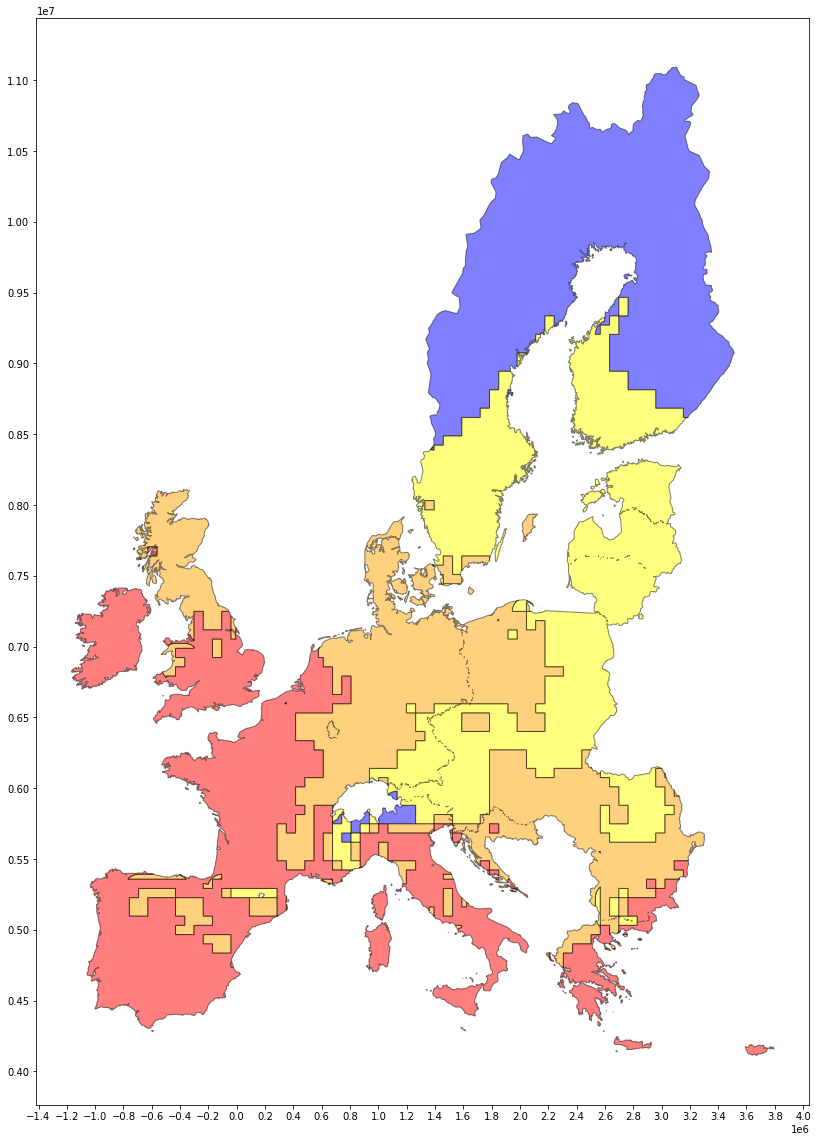

In [32]:
plt.clf()
ax = plt.figure(figsize=(20,20)).add_subplot(111)
colors = ['blue','yellow','orange','red']
for poly, color in zip(Cold_df['geometry'],colors):
    ax.add_patch(PolygonPatch(poly, fc=color, ec='black', alpha=0.5))
ax.axis('scaled')
plt.locator_params(axis='y', nbins=30)
plt.locator_params(axis='x', nbins=30)
plt.draw()
plt.show()

# Merge Sources

In [33]:
all_data = pd.concat([renew_df,energy_df,gas_df,elc_df,typo_df,stock_df],join='inner',axis=1).replace(': ',np.nan)

In [34]:
# clean numeric values
all_data.loc[:,all_data.dtypes == object] = all_data.loc[:,all_data.dtypes == object].apply(lambda col: col.str.extract('(\d+.\d+)', expand=False))
all_data.loc[:,all_data.dtypes == object] = all_data.loc[:,all_data.dtypes == object].astype(float)

In [35]:
all_data_dis = all_data.apply(lambda col: pd.qcut(col, 4, labels=False, duplicates = 'drop'))
all_data_dis = all_data_dis+1

In [36]:
eu_df.set_index('Code',inplace=True)
all_data_dis = pd.concat([all_data_dis,eu_df[['geometry']]],join='inner',axis=1)
all_data_dis = gpd.GeoDataFrame(all_data_dis)

In [37]:
all_data_dis = gpd.GeoDataFrame(all_data_dis)

In [38]:
discretization_cols = all_data.columns
gs_data = gpd.GeoDataFrame()
gs_data[discretization_cols] = all_data_dis[discretization_cols].apply(lambda col: all_data_dis.dissolve(by= col)['geometry'])
gs_data #table with polygon of the 4 quartiles of each feature

,renew share,energy cons,residential gas price,indus gas price,residential elec price,indus elec price,single family U value,multiple family U value,single family area (m2),mutiple family area (m2),Residential,Non-residential,single family,mutiple family
1.0,"MULTIPOLYGON (((-7600964.855 1353927.589, -760...","MULTIPOLYGON (((-1146332.292 6785384.989, -114...","MULTIPOLYGON (((532003.307 6697072.451, 530749...","MULTIPOLYGON (((-7601494.819 1355961.122, -760...","MULTIPOLYGON (((2089863.323 6360968.338, 20852...","MULTIPOLYGON (((-7601494.819 1355961.122, -760...","MULTIPOLYGON (((747620.997 7090275.595, 745972...","MULTIPOLYGON (((-1146332.292 6785384.989, -114...","MULTIPOLYGON (((-6859070.456 1788521.753, -685...","MULTIPOLYGON (((-6860026.202 1789816.725, -685...","MULTIPOLYGON (((-7601703.180 1358036.485, -760...","MULTIPOLYGON (((-6859070.456 1788521.753, -685...","MULTIPOLYGON (((-1997145.494 3212924.432, -199...","MULTIPOLYGON (((-7600964.855 1353927.589, -760..."
2.0,"MULTIPOLYGON (((-6859070.456 1788521.753, -685...","MULTIPOLYGON (((1304598.938 7965673.626, 13035...","MULTIPOLYGON (((748744.339 7090473.944, 747620...","MULTIPOLYGON (((-1996529.468 3213170.029, -199...","MULTIPOLYGON (((-7601703.180 1358036.485, -760...","MULTIPOLYGON (((1304598.938 7965673.626, 13035...","MULTIPOLYGON (((-1146332.292 6785384.989, -114...","MULTIPOLYGON (((749695.555 7090107.764, 748744...","MULTIPOLYGON (((-1146332.292 6785384.989, -114...","MULTIPOLYGON (((-1996529.468 3213170.029, -199...","MULTIPOLYGON (((-1149113.468 6782653.514, -115...","MULTIPOLYGON (((-1146332.292 6785384.989, -114...","MULTIPOLYGON (((748744.339 7090473.944, 747620...","MULTIPOLYGON (((-6859070.456 1788521.753, -685..."
3.0,"MULTIPOLYGON (((-1996529.468 3213170.029, -199...","MULTIPOLYGON (((-7601494.819 1355961.122, -760...","MULTIPOLYGON (((-6859070.456 1788521.753, -685...","MULTIPOLYGON (((-6859070.456 1788521.753, -685...","MULTIPOLYGON (((-1996529.468 3213170.029, -199...","MULTIPOLYGON (((-6859070.456 1788521.753, -685...","MULTIPOLYGON (((-6860026.202 1789816.725, -685...","MULTIPOLYGON (((-6859070.456 1788521.753, -685...","MULTIPOLYGON (((-7601703.180 1358036.485, -760...","MULTIPOLYGON (((747620.997 7090275.595, 745972...","MULTIPOLYGON (((942103.975 7442969.926, 940672...","MULTIPOLYGON (((530116.456 6694743.216, 532475...","MULTIPOLYGON (((-6859070.456 1788521.753, -685...","MULTIPOLYGON (((749695.555 7090107.764, 748744..."
4.0,"MULTIPOLYGON (((940971.574 7436628.407, 941814...","MULTIPOLYGON (((-6859070.456 1788521.753, -685...","MULTIPOLYGON (((-7601209.454 1361599.214, -760...","MULTIPOLYGON (((-1149113.468 6782653.514, -115...","MULTIPOLYGON (((-1149113.468 6782653.514, -115...","MULTIPOLYGON (((-1996529.468 3213170.029, -199...","MULTIPOLYGON (((-7601703.180 1358036.485, -760...","MULTIPOLYGON (((-7601703.180 1358036.485, -760...","MULTIPOLYGON (((-1996529.468 3213170.029, -199...","MULTIPOLYGON (((-7600964.855 1353927.589, -760...","MULTIPOLYGON (((-6859070.456 1788521.753, -685...","MULTIPOLYGON (((-7601703.180 1358036.485, -760...","MULTIPOLYGON (((-7600964.855 1353927.589, -760...","MULTIPOLYGON (((-1997145.494 3212924.432, -199..."


In [39]:
Hot_df.rename(columns={'geometry':'Hot_temp'},index={'bin':None},inplace=True)
Cold_df.rename(columns={'geometry':'Cold_temp'},index={'bin':None},inplace=True)

Final_geometry = pd.concat([gs_data,Cold_df,Hot_df],1)

In [40]:
Final_quartiles = gpd.GeoDataFrame(columns=Final_geometry.columns, index = Final_geometry.index)
#Create table with quartiles' pairs (edges of each bin)
for col in all_data:
    bins = pd.qcut(all_data[col], 4).values.categories
    for i, _bin in enumerate(bins):
        Final_quartiles[col][i+1]= _bin
        
Final_quartiles['Cold_temp'] = pd.qcut(cold_bins,4).categories
Final_quartiles['Hot_temp'] = pd.qcut(hot_bins,4).categories

# Save all

In [41]:
data = gpd.GeoDataFrame(pd.concat([Final_quartiles.stack(),Final_geometry.stack()],axis=1))

In [42]:
data.columns = ['quartiles','geometry']
data.set_geometry('geometry',inplace=True)
data.set_crs("EPSG:3857",inplace=True)
#data.to_crs("EPSG:4326",inplace=True)
#data

quartiles  \
1.0 renew share             (8.767000000000001, 12.389]   
    energy cons                    (1057.442, 5023.244]   
    residential gas price               (9.601, 15.633]   
    indus gas price                      (6.185, 7.471]   
    residential elec price               (0.0945, 0.15]   
...                                                 ...   
4.0 Non-residential                      (0.332, 0.393]   
    single family                        (0.611, 0.872]   
    mutiple family                        (0.558, 0.74]   
    Cold_temp                           (5.103, 13.653]   
    Hot_temp                            (16.635, 24.56]   

                                                                     geometry  
1.0 renew share             MULTIPOLYGON (((-7600964.855 1353927.589, -760...  
    energy cons             MULTIPOLYGON (((-1146332.292 6785384.989, -114...  
    residential gas price   MULTIPOLYGON (((532003.307 6697072.451, 530749...  
    indus gas price         MULTIPOLYGON (((-7601494.819 1355961.122, -760...  
    residential elec price  MULTIPOLYGON (((2089863.323 6360968.338, 20852...  
...                                                                       ...  
4.0 Non-residential         MULTIPOLYGON (((-7601703.180 1358036.485, -760...  
    single family           MULTIPOLYGON (((-7600964.855 1353927.589, -760...  
    mutiple family          MULTIPOLYGON (((-1997145.494 3212924.432, -199...  
    Cold_temp               MULTIPOLYGON (((-1160953.847 6780231.201, -115...  
    Hot_temp                MULTIPOLYGON (((-1010018.459 4695661.164, -101...  

[64 rows x 2 columns]

In [43]:
data['quartiles'] = data['quartiles'].apply(lambda x : str([x.left,x.right]))

In [ ]:
pt = Point(3.2692574723419057, 48.0494168686061)

WGS84 = pyproj.CRS('EPSG:4326')
WEB_PROJ = pyproj.CRS('EPSG:3857')
PROJECT = pyproj.Transformer.from_crs(WEB_PROJ, WGS84, always_xy=True).transform
PROJECT_REV = pyproj.Transformer.from_crs(WGS84, WEB_PROJ, always_xy=True).transform

pt = transform(PROJECT_REV, pt)

data[data.intersects(pt)]

In [ ]:
data.to_csv('output.csv')
#data.to_file('data.geojson',driver='GeoJSON')
#data.to_file(driver = 'ESRI Shapefile', filename= "data.shp")

In [ ]:
Final_geometry.to_csv('geometries.csv')

In [ ]:
Final_quartiles.to_csv('quartiles.csv')

# Find existing poly

4**16 = 4294967296 possibilities. Hard if not impossible to compute

In [ ]:
l,b,r,u = Cold_df.Cold_temp.values.unary_union().bounds
b,l = math.floor(b), math.floor(l)
u,r = math.ceil(u), math.ceil(r)

In [ ]:
grid_pts = [Point((i[0], i[1])) for i in list(product(Hot.x.values,Hot.y.values))]

In [ ]:
grid_pts = gpd.GeoDataFrame(grid_pts,columns=['geometry'])
eu_poly = gpd.GeoDataFrame(eu,columns=['geometry'])

In [ ]:
%%time
pts = gpd.overlay(grid_pts, eu_poly, how='intersection')

In [ ]:
def intersect_all_poly(l_poly):
    final = l_poly[0]
    for i in l_poly:
        final = i.intersection(final)
    return final 

combined_poly = []
for point in pts:
    polygons = [polygon for polygon in list(Final_geometry_stack.values) if point.within(polygon)]
    if len(polygons)>0:
        intersec = intersect_all_poly(polygons)
        combined_poly.append(intersec)

In [ ]:
%%time
exist = []
for point in pts.geometry.values:
    ids = []
    for label, content in Final_geometry.iteritems():
        for index in content.index:
            if point.within(content[index]):
                ids.append((index,label))
                break
    if len(ids) > 15:            
        exist.append(ids)

In [ ]:
def intersect_all_poly(l_poly):
    final = l_poly[0]
    for i in l_poly:
        final = i.intersection(final)
    return final 

truc = np.array(exist)
truc = np.unique(truc,axis=0)

combined_poly = []
for i in truc:
    polygons = []
    #quartiles = []
    for j in i:
        polygons.append(Final_geometry.loc[float(j[0]),j[1]])
        #quartiles.append(Final_quartile.loc[float(j[0]),truc[1]])

    intersec = intersect_all_poly(polygons)
    combined_poly.append(unary_union(intersec))

In [ ]:
df = gpd.GeoDataFrame(gpd.GeoSeries(combined_poly),columns=['geometry'],crs='EPSG:3857')

In [ ]:
import folium
import ast

center = eu

df.to_crs('EPSG:4326',inplace=True)

my_map = folium.Map(location=[53, 9],  tiles="cartodbpositron",zoom_start=9)

for geom in df.geometry: 
    folium.GeoJson(geom, style_function = lambda x: {'color': 'red'}).add_to(my_map)

my_map